This notebook contains the statistical analysis of the author-members of Shakespeare and Company. It consists of two parts: nationalities and book per authors. The first part is a simple analysis of the nationalities of the authors, while the second part is a more complex analysis of the number of books written by each author.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import entropy
import numpy as np

The following code imports the `sort_names` function from `utils.py`, which is used to sort the names of the author-members in the dataset. The function is stored in a separate file to keep the notebook clean and readable as it is used across multiple notebooks.

In [2]:
from utils import sort_names

Now the `member_is_author` DataFrame created in the previous notebook (01_intersection.ipynb) is loaded. It includes the names of the author-members and corresponding information. Moreover, the `books` DataFrame from Princeton University's Shakespeare and Company Project is loaded. It contains information about the books in the library of Shakespeare and Company.

In [3]:
member_is_author = pd.read_csv('../data/processed/table-data/01_member_is_author.csv', encoding='utf-8')
books = pd.read_csv('../data/raw/SCoData_books_v1.2_2022_01.csv', encoding='utf-8', dtype={'year': 'Int32'})

In [4]:
member_is_author.columns

Index(['uri', 'name', 'sort_name', 'title', 'gender', 'is_organization',
       'has_card', 'birth_year', 'death_year', 'membership_years', 'viaf_url',
       'wikipedia_url', 'nationalities', 'addresses', 'postal_codes',
       'arrondissements', 'coordinates', 'notes', 'updated'],
      dtype='object')

In [5]:
books.columns

Index(['uri', 'title', 'author', 'editor', 'translator', 'introduction',
       'illustrator', 'photographer', 'year', 'format', 'uncertain',
       'ebook_url', 'volumes_issues', 'notes', 'event_count', 'borrow_count',
       'purchase_count', 'circulation_years', 'updated'],
      dtype='object')

## Statistical Analysis

The statistical analysis involves the nationalities distribution of the author-members. The following steps will be performed:
* Calculation of the distribution
* Visualization
* Mode
* Entropy

### Nationalities

In [6]:
member_is_author.nationalities.sample(3)

69    France
57       NaN
40       NaN
Name: nationalities, dtype: object

Rows in `member_is_author` that do not have an entry in the `nationalities` column are removed, ensuring that only complete entries are retained for this specific analysis. Additionally, rows with multiple nationalities, represented as semicolon-separated strings, are split into distinct rows.

In [7]:
# Create a copy of the original DataFrame for processing
member_is_author_nationalities_df = member_is_author.copy()

# Replace missing values in the 'nationalities' column with the placeholder 'Unknown'
member_is_author_nationalities_df['nationalities'] = member_is_author_nationalities_df['nationalities'].fillna('Unknown')

# Split the 'nationalities' column into multiple columns using ';' as the delimiter
split_nationalities_df = member_is_author_nationalities_df['nationalities'].str.split(';', expand=True)

# Stack the resulting DataFrame so that each nationality appears in its own row
stacked_nationalities_series = split_nationalities_df.stack()\
    .reset_index(level=1, drop=True)\
    .rename('nationalities')

# Drop the original 'nationalities' column and join the stacked nationalities
nationalities_df = member_is_author_nationalities_df.drop('nationalities', axis=1).join(stacked_nationalities_series)

# Display the resulting DataFrame
print(nationalities_df.head(5))

                                                 uri                  name  \
0  https://shakespeareandco.princeton.edu/members...     Richard Aldington   
1  https://shakespeareandco.princeton.edu/members...  Margaret C. Anderson   
2  https://shakespeareandco.princeton.edu/members...        George Antheil   
3  https://shakespeareandco.princeton.edu/members...          Louis Aragon   
4  https://shakespeareandco.princeton.edu/members...           Nathan Asch   

               sort_name title  gender  is_organization  has_card  birth_year  \
0     Aldington, Richard   NaN    Male            False      True      1892.0   
1  Anderson, Margaret C.   NaN  Female            False     False      1886.0   
2        Antheil, George   NaN    Male            False     False      1900.0   
3          Aragon, Louis   NaN    Male            False      True      1897.0   
4           Asch, Nathan   NaN    Male            False     False      1902.0   

   death_year membership_years              

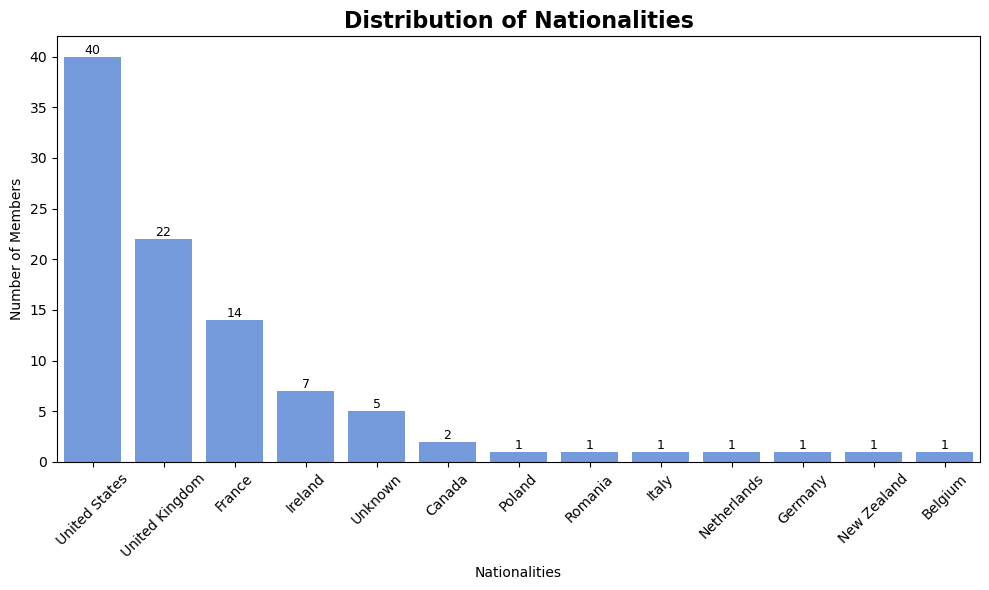

In [8]:
# Count the number of occurrences of each nationality
nationality_counts = nationalities_df['nationalities'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=nationality_counts.index, y=nationality_counts.values, color='cornflowerblue')
plt.title('Distribution of Nationalities', fontsize=16, fontweight='bold')
plt.xlabel('Nationalities')
plt.ylabel('Number of Members')
plt.xticks(rotation=45)
for i, count in enumerate(nationality_counts.values):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../data/processed/figure-images/03_bar_nationalities_distribution.png',bbox_inches='tight')
plt.show()

In [9]:
# Group by nationality and aggregate the sort_name column
names_by_nationality_initial = (
    nationalities_df.groupby('nationalities')
    .agg({'sort_name': lambda x: sort_names(list(set(x)))})  # Deduplicate and format names
    .reset_index()
)

# Create a new GeoDataFrame that includes a column counting the number of names in each group.
names_by_nationality_with_count = names_by_nationality_initial.assign(
    count_names=lambda df: df['sort_name'].apply(lambda x: len(x.split(', ')))
)

# Create a final GeoDataFrame by sorting by the new count column in descending order.
names_by_nationality = names_by_nationality_with_count.sort_values('count_names', ascending=False).reset_index(drop=True)

print(names_by_nationality)

     nationalities                                          sort_name  \
0    United States  Allen Tate, Archibald MacLeish, Djuna Barnes, ...   
1   United Kingdom   Bryher, Anna Wickham, C. K. Ogden, Cyril Conn...   
2           France  André Gide, Eugene Jolas, Henri Michaux, Jean ...   
3          Ireland  Austin Clarke, James Joyce, Kathleen Coyle, Pa...   
4          Unknown  Elizabeth Clark, Frank Harris, Louis Bromfield...   
5           Canada                        Leon Edel, Morley Callaghan   
6          Belgium                                      Henri Michaux   
7          Germany                                    Ludwig Lewisohn   
8            Italy                                   Stanislaus Joyce   
9      Netherlands                                        Odette Keun   
10     New Zealand                                Katherine Mansfield   
11          Poland                                        Nathan Asch   
12         Romania                                 

In [10]:
# Export the DataFrame to CSV
names_by_nationality.to_csv(
    '../data/processed/table-data/03_member_is_author_nationalities.csv',
    index=False,
    encoding='utf-8'
)

In [11]:
# Filter the DataFrame to include only authors that have an unknown nationality
list_author_by_nationality = names_by_nationality[names_by_nationality['nationalities'] == 'Unknown']['sort_name'].unique()

print(f"Filtered nationality: {list_author_by_nationality}")

Filtered nationality: ['Elizabeth Clark, Frank Harris, Louis Bromfield, Ruth McKenney, Élisabeth de Gramont']


In [12]:
# Calculation of percentages by nationality
percentages_nationalities_initial = nationalities_df['nationalities'].value_counts(normalize=True) * 100

# Round the percentages to two decimal places
percentages_nationalities = percentages_nationalities_initial.round(2)

print(percentages_nationalities)

United States     41.24
United Kingdom    22.68
France            14.43
Ireland            7.22
Unknown            5.15
Canada             2.06
Poland             1.03
Romania            1.03
Italy              1.03
Netherlands        1.03
Germany            1.03
New Zealand        1.03
Belgium            1.03
Name: nationalities, dtype: float64


English-speaking countries:

In [13]:
# Calculation of the percentage of English-speaking countries represented in the dataset
english_speaking_countries = percentages_nationalities[0] + percentages_nationalities[1] + percentages_nationalities[3] + percentages_nationalities[5] + percentages_nationalities[11]

print(f"Percentage of English-speaking countries: {english_speaking_countries.round(2)}%")

Percentage of English-speaking countries: 74.23%


#### Mode

In [14]:
# Calculate the mode of the nationalities distribution
mode_nationalities = nationalities_df['nationalities'].value_counts().idxmax()
print(f"Mode of nationalities distribution: {mode_nationalities}")

Mode of nationalities distribution: United States


#### Entropy

In [15]:
def calculate_entropy(distribution):
    """
    Calculate the entropy of a given distribution.

    Parameters:
        distribution (array-like): A probability distribution for which the entropy is to be calculated.

    Returns:
        float: The entropy of the distribution.

    Raises:
        ValueError: If the distribution is not valid or if it contains negative probabilities.
    """
    return entropy(distribution)

def calculate_max_entropy(num_categories):
    """
    Calculate the maximum possible entropy for a given number of categories.

    Entropy is a measure of the uncertainty or randomness in a system. The maximum entropy is achieved when all categories are equally likely.

    Parameters:
        num_categories (int): The number of categories.

    Returns:
        float: The maximum possible entropy for the given number of categories.

    Raises:
        ValueError: If num_categories is not a positive integer.
    """
    return np.log(num_categories)

def calculate_normalized_entropy(distribution):
    """
    Calculate the normalized entropy of a given distribution.

    Normalized entropy is the ratio of the entropy of the distribution to the 
    maximum possible entropy for a distribution of the same size. This value 
    ranges from 0 to 1, where 0 indicates no entropy (completely predictable 
    distribution) and 1 indicates maximum entropy (completely unpredictable 
    distribution).

    Args:
        distribution (list or array-like): The distribution for which to 
        calculate the normalized entropy.

    Returns:
        float: The normalized entropy of the distribution.
    """
    ent = calculate_entropy(distribution)
    max_ent = calculate_max_entropy(len(distribution))
    return ent / max_ent

In [16]:
# Calculate the entropy of the nationalities distribution

# Calculate the value counts of the nationalities
nationalities_counts = nationalities_df['nationalities'].value_counts(normalize=True)

# Calculate the entropy of the nationalities distribution
entropy_nationalities = calculate_entropy(nationalities_counts)

# Calculate the maximum possible entropy with the current number of categories
max_entropy_nationalities = calculate_max_entropy(len(nationalities_counts))

# Calculate the normalized entropy of the nationalities distribution
normalized_entropy_nationalities = calculate_normalized_entropy(nationalities_counts)

print(f"Entropy of nationalities distribution: {entropy_nationalities.round(2)}")

print(f"Maximum possible entropy with {len(nationalities_counts)} categories: {max_entropy_nationalities.round(2)}")

print(f"Normalized entropy: {normalized_entropy_nationalities.round(2)}")

Entropy of nationalities distribution: 1.73
Maximum possible entropy with 13 categories: 2.56
Normalized entropy: 0.68


### Books per Author-Member

In [17]:
member_is_author.shape

(84, 19)

In [18]:
member_is_author.columns

Index(['uri', 'name', 'sort_name', 'title', 'gender', 'is_organization',
       'has_card', 'birth_year', 'death_year', 'membership_years', 'viaf_url',
       'wikipedia_url', 'nationalities', 'addresses', 'postal_codes',
       'arrondissements', 'coordinates', 'notes', 'updated'],
      dtype='object')

#### Overall comparison of books by members

The analysis of books authored by members of the author group begins with an assessment of the proportion of unique book titles authored by these individuals. The `books` DataFrame is filtered to include only rows where the `author` column matches any names in the `member_is_author` DataFrame and in which the `format`is 'Book'.

In [19]:
# Filter the books DataFrame to include only books by author-members
titles_by_member = books[books['author'].isin(member_is_author['sort_name'])]

# Filter the DataFrame to keep only rows where format is 'Book'
books_by_member = titles_by_member[titles_by_member['format'] == 'Book']

books_filtered = books[books['format'] == 'Book']

# Calculate the number of unique titles
total_unique_books = len(books_filtered['uri'].unique())
unique_books_by_member = len(books_by_member['uri'].unique())

print(f"Number of unique books overall: {total_unique_books}")

print(f"Number of unique books authored by author-members: {unique_books_by_member}")

Number of unique books overall: 5512
Number of unique books authored by author-members: 316


The filtered dataset, referred to as `books_by_member`, serves as the basis for this analysis.

In [20]:
# Export the DataFrame to CSV
books_by_member.to_csv(
    '../data/processed/table-data/03_member_is_author_titles.csv',
    index=False,
    encoding='utf-8'
)

In [21]:
# Calculate the percentage of unique titles by author-members out of the total
percentage_of_books_by_members = round(((unique_books_by_member / total_unique_books) * 100), 2)

print(f"Percentage of unique titles by members: {percentage_of_books_by_members}%")

Percentage of unique titles by members: 5.73%


#### How many books does each author have?

Then the analysis examines the number of books available in the library for each author-member. Simply, the distribution of the 316 titles across the 84 author-members is calculated.

In [22]:
# Group by 'author' and count the number of books for each author
books_count_by_member_initial = books_by_member.groupby('author')['title'].count().sort_values(ascending=False)

# Reset the index
books_count_by_member = books_count_by_member_initial.reset_index()
books_count_by_member.columns = ['author', 'numberOfBooks']

# Display the result
print("The number of books by each author-member:")
print(books_count_by_member.head(15))

The number of books by each author-member:
                  author  numberOfBooks
0       Ford, Ford Madox             18
1            Pound, Ezra             16
2           Joyce, James             13
3      Hemingway, Ernest             11
4       Bromfield, Louis             11
5        Stein, Gertrude             11
6        McAlmon, Robert             10
7       Spender, Stephen              9
8       Merrick, Leonard              9
9   Mansfield, Katherine              9
10      Lewisohn, Ludwig              9
11    Aldington, Richard              9
12    Huddleston, Sisley              8
13   MacLeish, Archibald              8
14         Harris, Frank              8


Determining the number of rows in which the `numberOfBooks` is only 1. This information is used to calculate the percentage of authors who have only one book in the library.

In [23]:
# Count the number of rows where numberOfBooks is 1
rows_with_one_book = books_count_by_member[books_count_by_member['numberOfBooks'] == 1].shape[0]

# Calculate the percentage
total_rows = len(books_count_by_member)
percentage_rows_with_one_book = (rows_with_one_book / total_rows) * 100

# Display the result
print(f"The percentage of author-member who had only one book available at the lending library: {round(percentage_rows_with_one_book, 2)}%")

The percentage of author-member who had only one book available at the lending library: 36.9%


Now the `books_count_by_member` DataFrame is altered to include only the top 23 member-authors with the most books in the library. This subset is used to create a bar plot that visualizes the number of books each author has in the library. The cutoff point of 23 was chosen as it represents the author-members with a minimum of five book in the library.

In [24]:
highest_books_count = books_count_by_member.nlargest(23, 'numberOfBooks')

Then the bar plot is created to visualize the number of books each author has in the library. The plot is sorted in descending order to highlight the authors with the most books.

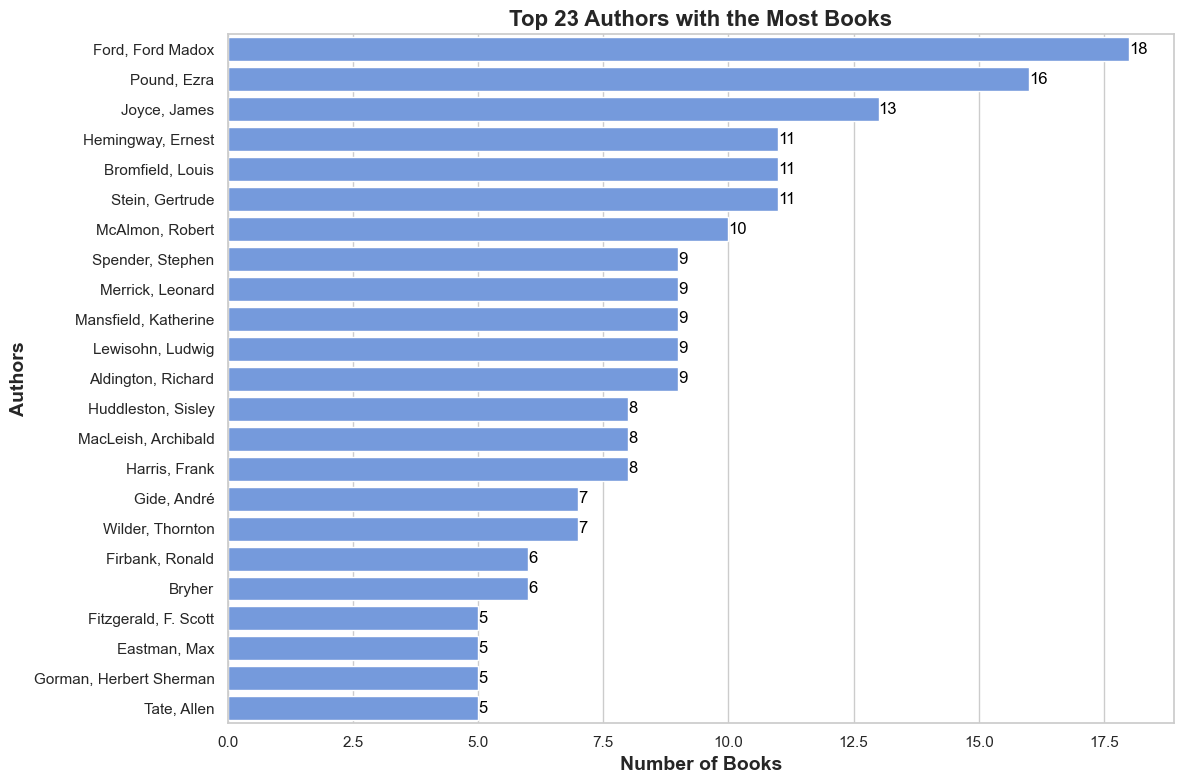

In [25]:
# Create the plot with a modern style
plt.figure(figsize=(12, 8))  # Set the figure size
sns.set_theme(style="whitegrid")  # Set the seaborn style

# Create the bar plot
bar_plot = sns.barplot(x='numberOfBooks', y='author', data=highest_books_count, color='cornflowerblue')

# Add labels and title with improved styling
plt.xlabel('Number of Books', fontsize=14, fontweight='bold')
plt.ylabel('Authors', fontsize=14, fontweight='bold')
plt.title('Top 23 Authors with the Most Books', fontsize=16, fontweight='bold')

# Add values on the bars for better readability
for index, value in enumerate(highest_books_count['numberOfBooks']):
    bar_plot.text(value, index, f'{value}', color='black', ha="left", va="center", fontsize=12)

plt.tight_layout()
plt.savefig('../data/processed/figure-images/03_bar_top_authors_books.png',bbox_inches='tight')
plt.show()